In [5]:
# Load and inspect the data
import pandas as pd

data = pd.read_csv('/content/traffic_accident_data.csv')
data.head()

,Accident_ID,Date,Time,Location,Weather,Road_Condition,Severity,Latitude,Longitude
0,1,2023-10-18,01:06:08,Zuniga Rue & Jared Streets,Rain,Dry,High,-81.895150,173.384322
1,2,2024-08-31,14:09:12,Case Route & Tina Parkways,Fog,Snowy,Low,-73.328793,-0.485409
2,3,2023-09-26,14:59:33,Abigail Manors & Jason Route,Hail,Dry,High,-85.906279,53.120868
3,4,2024-04-17,12:12:12,Jackson Squares & Olivia Corner,Snow,Wet,Low,17.270556,12.436578
4,5,2023-09-29,14:50:44,Hodges Parkway & Daniel Lakes,Rain,Slippery,High,-9.343667,128.980533


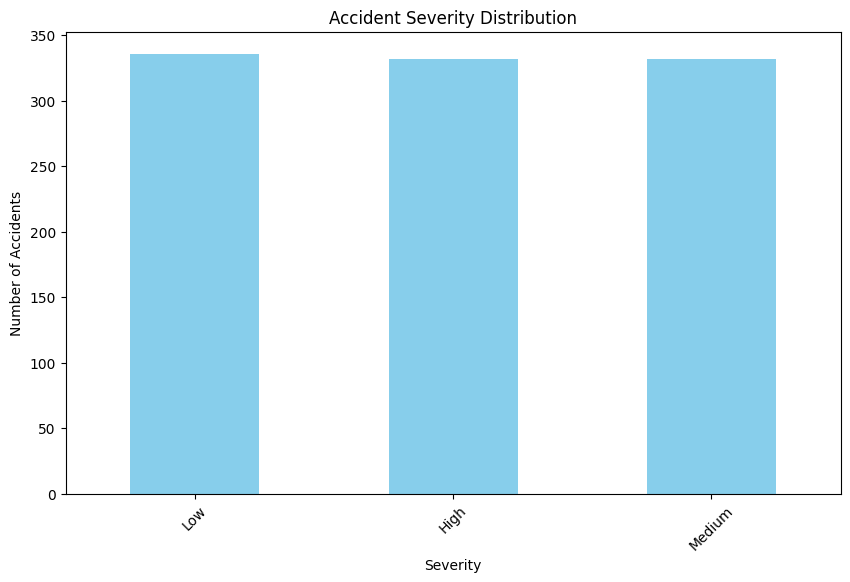

In [6]:
# Analyze and visualize the distribution of accident severity
import matplotlib.pyplot as plt

severity_counts = data['Severity'].value_counts()
plt.figure(figsize=(10, 6))
severity_counts.plot(kind='bar', color='skyblue')
plt.title('Accident Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

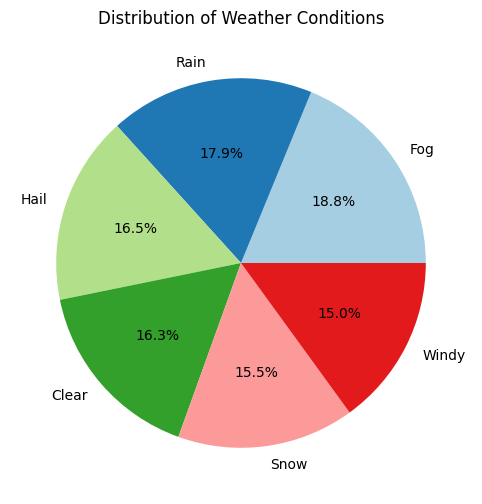

In [7]:
# Analyze and visualize the distribution of weather conditions
weather_counts = data['Weather'].value_counts()
plt.figure(figsize=(10, 6))
weather_counts.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Distribution of Weather Conditions')
plt.ylabel('')
plt.show()

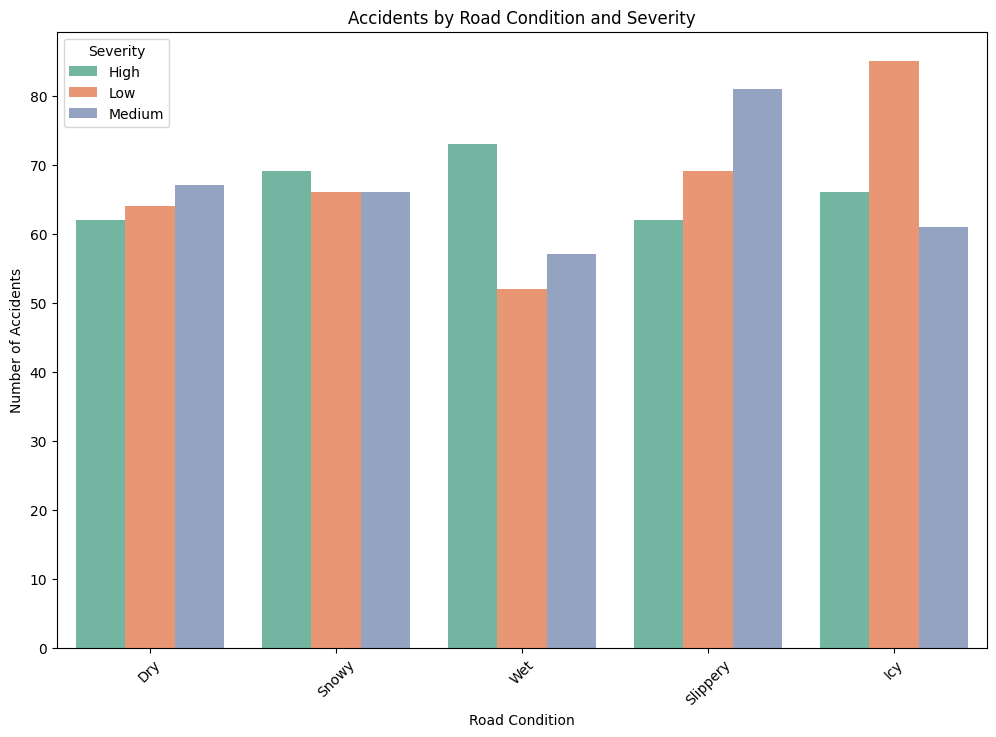

In [8]:
# Analyze and visualize the relationship between road conditions and severity
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='Road_Condition', hue='Severity', palette='Set2')
plt.title('Accidents by Road Condition and Severity')
plt.xlabel('Road Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

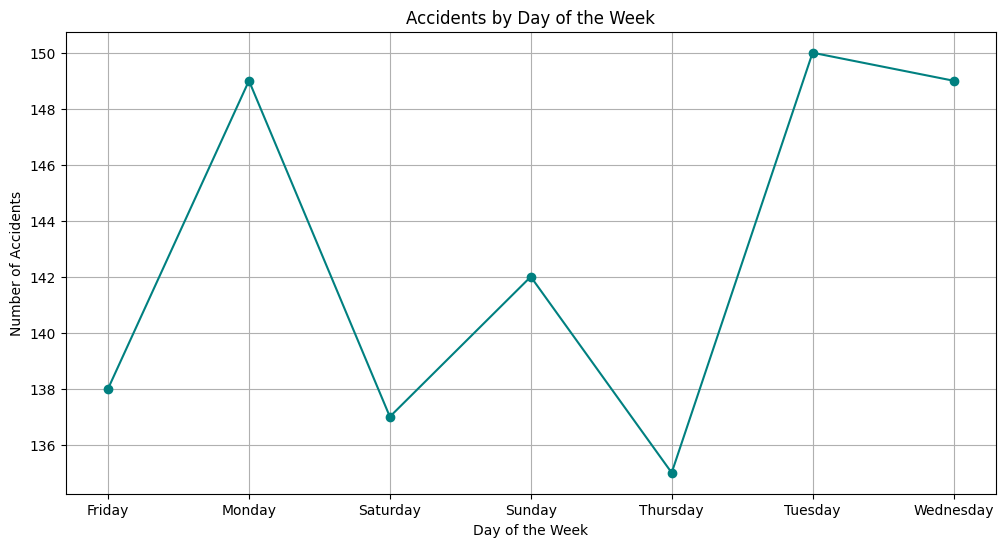

In [9]:
# Analyze and visualize the number of accidents over time
data['Date'] = pd.to_datetime(data['Date'])
data['DayOfWeek'] = data['Date'].dt.day_name()
daily_accidents = data.groupby('DayOfWeek').size()

plt.figure(figsize=(12, 6))
daily_accidents.plot(kind='line', marker='o', color='teal')
plt.title('Accidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


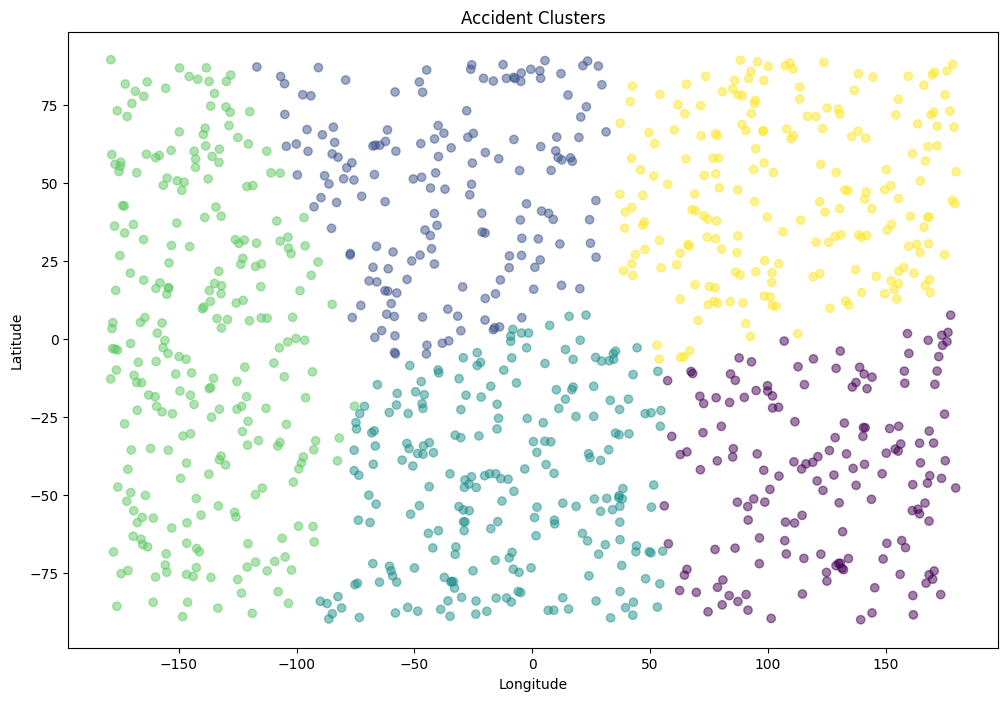

In [13]:
from sklearn.cluster import KMeans
import numpy as np

# Prepare data for clustering
coords = data[['Latitude', 'Longitude']].dropna().values
kmeans = KMeans(n_clusters=5)  # You can adjust the number of clusters
clusters = kmeans.fit_predict(coords)

# Plot clusters
plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 1], coords[:, 0], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Accident Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

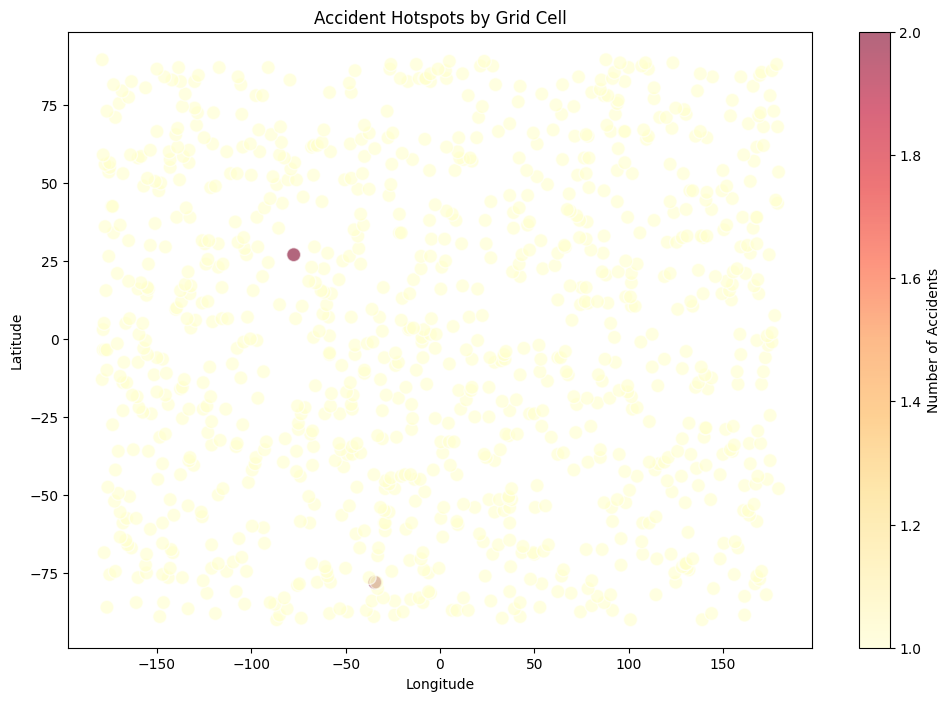

In [14]:
import numpy as np

# Define grid size
grid_size = 0.5
data['Grid_Lat'] = np.floor(data['Latitude'] / grid_size) * grid_size
data['Grid_Lon'] = np.floor(data['Longitude'] / grid_size) * grid_size

# Count accidents per grid cell
grid_counts = data.groupby(['Grid_Lat', 'Grid_Lon']).size().reset_index(name='Accident_Count')

plt.figure(figsize=(12, 8))
plt.scatter(grid_counts['Grid_Lon'], grid_counts['Grid_Lat'], c=grid_counts['Accident_Count'], cmap='YlOrRd', alpha=0.6, edgecolors='w', s=100)
plt.colorbar(label='Number of Accidents')
plt.title('Accident Hotspots by Grid Cell')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<ipython-input-16-43110e24edb4>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time'] = pd.to_datetime(data['Time']).dt.hour


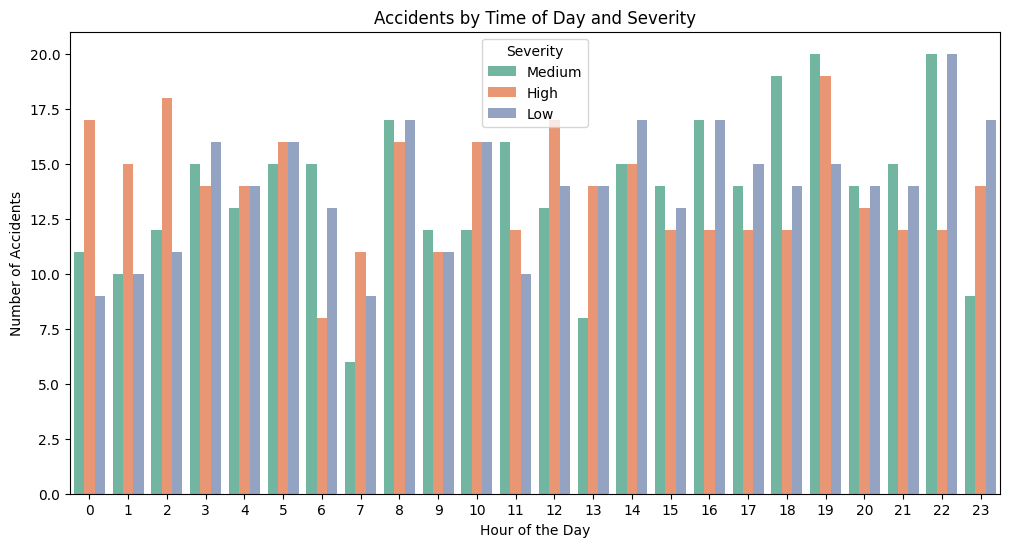

In [16]:
# Time of day analysis
data['Time'] = pd.to_datetime(data['Time']).dt.hour
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Time', hue='Severity', palette='Set2')
plt.title('Accidents by Time of Day and Severity')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(range(24))
plt.show()

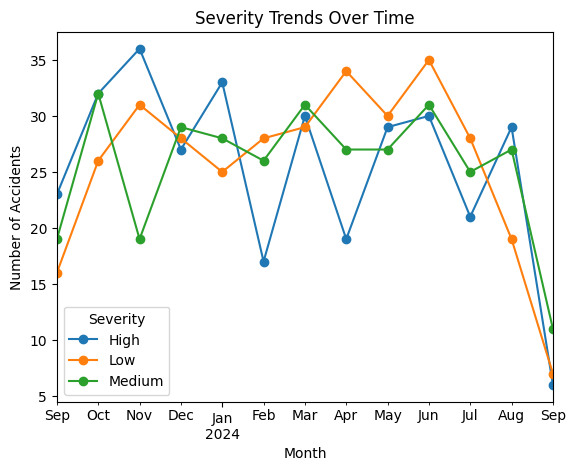

In [17]:
# Severity trends over time
data['Month'] = data['Date'].dt.to_period('M')
severity_trends = data.groupby(['Month', 'Severity']).size().unstack().fillna(0)
severity_trends.plot(kind='line', marker='o')
plt.title('Severity Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.show()

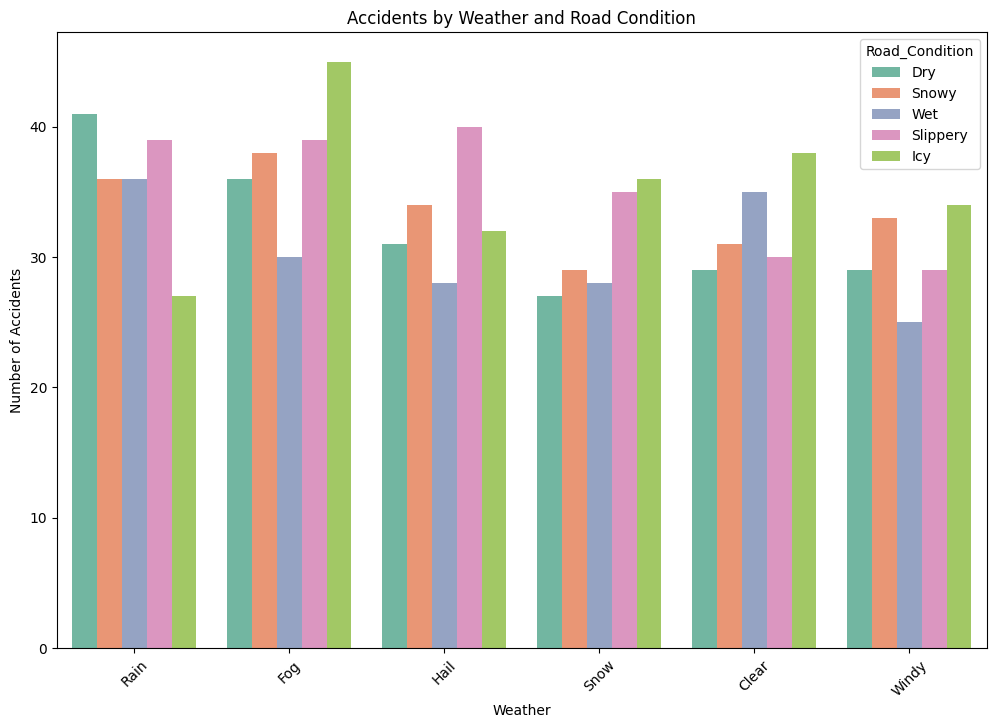

In [18]:
# Weather and road condition interaction
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='Weather', hue='Road_Condition', palette='Set2')
plt.title('Accidents by Weather and Road Condition')
plt.xlabel('Weather')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

In [28]:
!pip install geopandas folium

In [30]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import display

# Load your data
data = pd.read_csv('/content/traffic_accident_data.csv')

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['Longitude'], data['Latitude']),
    crs="EPSG:4326"
)

# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Ensure your points are within land areas
gdf = gdf[gdf.geometry.within(world.unary_union)]

# Create a base map
map_center = [gdf['Latitude'].mean(), gdf['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Add filtered accident locations to the map
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color='red' if row['Severity'] == 'High' else 'blue',
        fill=True,
        fill_color='red' if row['Severity'] == 'High' else 'blue'
    ).add_to(m)

# Display the map
display(m)

<ipython-input-30-afe3603c1950>:18: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

